# Paper Replication: (Re-)Imag(in)ing Price Trends

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
# import libraries
import pandas as pd
import numpy as np
import os.path as op
import time
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm

/home/honglanqing/anaconda3/envs/kc_llava/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# define constants
DATA_ROOT = '../../datasets/price_trends/monthly_20d'  # change this to yours

# the two below are given by https://dachxiu.chicagobooth.edu/download/img_demo.html
IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}

# these below are all from the paper
YEAR_START = 1993
YEAR_END = 2019    # inclusive
YEAR_SPLIT = 2000  # 1993-1999 for training/validation, 2000-2019 for testing

VALIDATION_PORTION = 0.3
BATCH_SIZE = 128
INIT_LR = 1e-5

PATIENCE = 2       # early stopping patience

# other constants
DAYS_OF_RET = 20
NUM_WORKERS = 0
MAX_EPOCHS = 50

### Load and split data
In the original paper, they use first seven-year sample (1993-1999) to train
and validate model, in which 70% of the sample are randomly selected for training and
the remaining 30% for validation. The remaining twenty years of data comprise the
out-of-sample test dataset.



In [4]:
class OHLC20DaysDataset(torch.utils.data.Dataset):
    def __init__(self, data_root, year):
        images_path = op.join(data_root, f'20d_month_has_vb_[20]_ma_{year}_images.dat')
        images = np.memmap(images_path, dtype=np.uint8, mode='r')
        images = images.reshape((-1, 1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))

        labels_path = op.join(data_root, f'20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather')
        labels_df = pd.read_feather(labels_path)
        labels = labels_df[f'Ret_{DAYS_OF_RET}d']

        missing = labels.isna()
        images = images[~missing]
        labels = labels[~missing]
        print(f'year {year}: {sum(missing)} data with missing label ignored')

        self.images = torch.tensor(images, dtype=torch.float)
        self.labels = torch.tensor(labels > 0, dtype=torch.long)
        
    def __getitem__(self, index):
        return self.images[index], self.labels[index]
    
    def __len__(self):
        return self.images.size(0)

datasets = []

for year in range(YEAR_START, YEAR_END+1):
    dataset = OHLC20DaysDataset(DATA_ROOT, year)
    datasets.append(dataset)

# divide sample into two parts
# the first seven years as the training/validation set, and the rest as the test set
train_and_valid_data = torch.utils.data.ConcatDataset(datasets[:YEAR_SPLIT-YEAR_START]) 
test_data = torch.utils.data.ConcatDataset(datasets[YEAR_SPLIT-YEAR_START:])

# split train_and_valid_data into training and validation data 
num_train_and_valid = len(train_and_valid_data)
indices = list(range(num_train_and_valid))
np.random.shuffle(indices)
split = round(VALIDATION_PORTION * num_train_and_valid)
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation data separately
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

# define dataloaders for train, validation, and test data
train_loader = torch.utils.data.DataLoader(train_and_valid_data,
                                           batch_size=BATCH_SIZE,
                                           sampler=train_sampler,
                                           num_workers=NUM_WORKERS,
                                           drop_last=True)

valid_loader = torch.utils.data.DataLoader(train_and_valid_data,
                                           batch_size=BATCH_SIZE,
                                           sampler=valid_sampler,
                                           num_workers=NUM_WORKERS)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS)

year 1993: 365 data with missing label ignored
year 1994: 528 data with missing label ignored
year 1995: 668 data with missing label ignored
year 1996: 636 data with missing label ignored
year 1997: 847 data with missing label ignored
year 1998: 1095 data with missing label ignored
year 1999: 1059 data with missing label ignored
year 2000: 1056 data with missing label ignored
year 2001: 992 data with missing label ignored
year 2002: 733 data with missing label ignored
year 2003: 611 data with missing label ignored
year 2004: 495 data with missing label ignored
year 2005: 541 data with missing label ignored
year 2006: 550 data with missing label ignored
year 2007: 762 data with missing label ignored
year 2008: 893 data with missing label ignored
year 2009: 523 data with missing label ignored
year 2010: 448 data with missing label ignored
year 2011: 411 data with missing label ignored
year 2012: 406 data with missing label ignored
year 2013: 347 data with missing label ignored
year 2014:

### Construct the network
According to the paper:
- we use 5 × 3 convolutional filters and 2 × 1 max-pooling filters (same filter sizes are used in all layers for convenience)
- we use a vertical stride of 3, and a vertical dilation rate of 2 for 20-day images only on the first layer where inputs are sparse raw images
- for elements at the image’s border, we fill the absent neighbor elements with zeros in order to compute the convolution
- we use a batch normalization layer between the convolution and nonlinear activation within each building block
- the activation function we use is “leaky ReLU” (with k=0.01) 
- use 3 blocks for 20-day images
- increase the number of filters after each convolutional layer by a factor of two (64, 128, 256)
- the fully connected layer have 46,080 (=256 * 3 * 60) neurons for the 20-day model
- we apply 50% dropout (Srivastava et al. (2014)) to the fully connected layer
- total number of parameters are 708,866 for the 20-day model
- we apply the Xavier initializer for weights in each layer

In [5]:
class CNN20Days(nn.Module):
    # expected input tensor size: (1, 64, 60)
    def __init__(self):
        super(CNN20Days, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(5,3),  # output shape:
                      stride=(3,1), dilation=(2,1), padding=(4,1)),        # (64, 22, 60)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=(2,1)),                               # (64, 11, 60)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5,3),
                      padding=(2,1)),                                      # (128, 11, 60)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=(2,1), ceil_mode=True),               # (128, 6, 60)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(5,3),
                      padding=(2,1)),                                      # (256, 6, 60)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=(2,1)),                               # (256, 3, 60)
        )
        
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(256 * 3 * 60, 2)                               # (2,)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.dropout(x.flatten(1))
        x = self.fc(x)
        return x

model = CNN20Days()
model

CNN20Days(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(4, 1), dilation=(2, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=True)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=Fa

In [6]:
total_num_training_parameters = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        total_num_training_parameters += np.product(param.size())
total_num_training_parameters

708866

### Implement early stopping

In [7]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.val_loss_min != np.Inf:
            if self.verbose:
                self.trace_func(f'Validation loss decreased by {self.val_loss_min-val_loss:e}.  Saving model ...')
            torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Train the model with early stopping

In [8]:
class AverageMeter:
    def __init__(self):
        self.n = 0
        self.s = 0

    def update(self, n, m):
        self.n += n
        self.s += m * n

    @property
    def average(self):
        return self.s / self.n


def train_model(model, patience, max_epochs, init_lr, device):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

    since = time.time()
    checkpoint_path = f'checkpoint.{DAYS_OF_RET}ret.pt'
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=checkpoint_path)
    train_loss_stats = []
    valid_loss_stats = []

    def train_epoch():
        train_loss = AverageMeter()
        model.train()  # set the model in training mode
        for i, (data, target) in tqdm(enumerate(train_loader), desc=f'  Training progress',
                                      total=len(train_loader)):
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            loss = criterion(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss.update(data.size(0), loss.item())
            train_loss_stats.append((epoch + i / len(train_loader), loss.item()))
        return train_loss

    def eval():
        valid_loss = AverageMeter()
        model.eval()  # set the model in evaluation mode
        for data, target in tqdm(valid_loader, desc=f'Validation progress'):
            data = data.to(device)
            target = target.to(device)

            with torch.no_grad():
                output = model(data)
                loss = criterion(output, target)

            valid_loss.update(data.size(0), loss.item())
        valid_loss_stats.append((epoch + 1, valid_loss.average))
        return valid_loss

    print('### Initial validation')
    epoch = -1
    valid_loss = eval()
    print(f'Validation loss: {valid_loss.average:.3e}')
    early_stopping(valid_loss.average, model)

    print('### Training started')
    for epoch in range(max_epochs):
        print(f'### Epoch {epoch+1:2d}/{max_epochs}')
        train_loss = train_epoch()
        valid_loss = eval()

        print(f'  Training loss: {train_loss.average:.3e}')
        print(f'Validation loss: {valid_loss.average:.3e}')
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss.average, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(checkpoint_path))
    
    # report the time on training
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    return train_loss_stats, valid_loss_stats

In [9]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")
model = CNN20Days()
train_loss_stats, valid_loss_stats = train_model(model, PATIENCE, MAX_EPOCHS, INIT_LR, device)

### Initial validation


Validation progress: 100%|██████████| 1617/1617 [00:15<00:00, 104.65it/s]


Validation loss: 3.311e+00
### Training started
### Epoch  1/50


Validation progress: 100%|██████████| 1617/1617 [00:15<00:00, 104.68it/s]


  Training loss: 9.701e-01
Validation loss: 7.070e-01
Validation loss decreased by 2.604319e+00.  Saving model ...
### Epoch  2/50


Validation progress: 100%|██████████| 1617/1617 [00:14<00:00, 111.58it/s]


  Training loss: 8.304e-01
Validation loss: 7.056e-01
Validation loss decreased by 1.365371e-03.  Saving model ...
### Epoch  3/50


Validation progress: 100%|██████████| 1617/1617 [00:14<00:00, 111.57it/s]


  Training loss: 7.653e-01
Validation loss: 6.952e-01
Validation loss decreased by 1.044342e-02.  Saving model ...
### Epoch  4/50


Validation progress: 100%|██████████| 1617/1617 [00:14<00:00, 109.76it/s]


  Training loss: 7.330e-01
Validation loss: 6.914e-01
Validation loss decreased by 3.805812e-03.  Saving model ...
### Epoch  5/50


Validation progress: 100%|██████████| 1617/1617 [00:14<00:00, 109.98it/s]


  Training loss: 7.174e-01
Validation loss: 6.896e-01
Validation loss decreased by 1.783093e-03.  Saving model ...
### Epoch  6/50


Validation progress: 100%|██████████| 1617/1617 [00:14<00:00, 109.19it/s]


  Training loss: 7.083e-01
Validation loss: 6.892e-01
Validation loss decreased by 4.619129e-04.  Saving model ...
### Epoch  7/50


Validation progress: 100%|██████████| 1617/1617 [00:14<00:00, 109.98it/s]


  Training loss: 7.022e-01
Validation loss: 6.886e-01
Validation loss decreased by 5.283658e-04.  Saving model ...
### Epoch  8/50


Validation progress: 100%|██████████| 1617/1617 [00:14<00:00, 111.08it/s]


  Training loss: 6.982e-01
Validation loss: 6.967e-01
EarlyStopping counter: 1 out of 2
### Epoch  9/50


Validation progress: 100%|██████████| 1617/1617 [00:14<00:00, 108.90it/s]

  Training loss: 6.952e-01
Validation loss: 6.897e-01
EarlyStopping counter: 2 out of 2
Early stopping
Training complete in 16m 51s


In [10]:
# save model
path = f'checkpoint.{DAYS_OF_RET}ret.best.pt'
torch.save(model.state_dict(), path)

### Visualize the training process


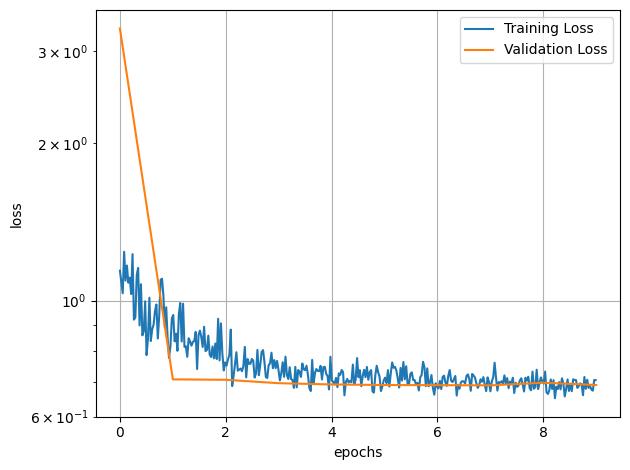

In [17]:
fig = plt.figure()

def ema(values, period):
    values = pd.DataFrame(values)
    return values.ewm(com=9).mean()

window_size = 100
x, y = zip(*train_loss_stats)
# y = ema(y, window_size)
plt.plot(x[::100], y[::100], label='Training Loss')
plt.plot(*zip(*valid_loss_stats), label='Validation Loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# fig.savefig('loss_plot.png', bbox_inches='tight')

### Test the network

In [12]:
# load model parameter
model = CNN20Days()
path = f'checkpoint.{DAYS_OF_RET}ret.best.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [15]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

TP = TN = FP = FN = 0
model = model.to(device)
model.eval()  # set the model in evaluation mode
for data, target in tqdm(test_loader, desc=f'Test progress'):
    data = data.to(device)
    target = target.to(device)

    with torch.no_grad():
        output = model(data)

    _, preds = output.max(dim=1)

    TP += ((preds == target) & (target == 1)).sum()
    TN += ((preds == target) & (target == 0)).sum()
    FP += ((preds != target) & (target == 0)).sum()
    FN += ((preds != target) & (target == 1)).sum()

accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)
f1 = 2 * recall * precision / (recall + precision)
print(f'accuracy:  {accuracy:.3f}')
print(f'recall:    {recall:.3f}')
print(f'precision: {precision:.3f}')
print(f'f1:        {f1:.3f}')

Test progress: 100%|██████████| 11648/11648 [01:14<00:00, 156.22it/s]

accuracy:  0.530
recall:    0.694
precision: 0.537
f1:        0.605


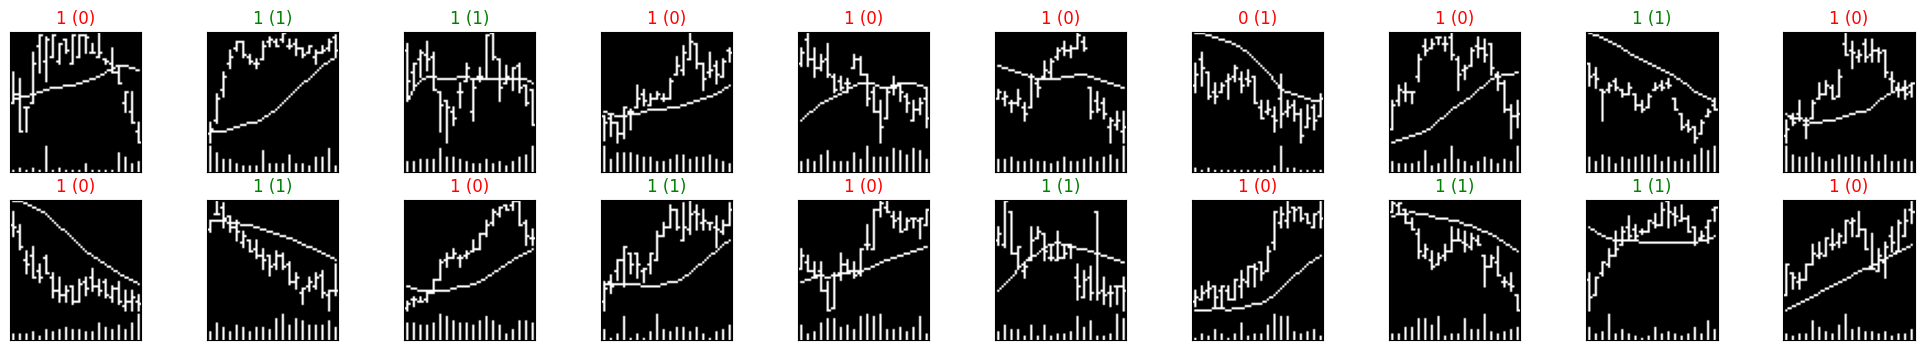

In [14]:
images = data.cpu().numpy()
labels = target.cpu().numpy()
preds_ = preds.cpu().numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds_[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))